# Use Gradient Descend to Do STO-NG Decomposition

&emsp;&emsp;STO-NG is a common method in quantum chemistry, by which the electron orbitals are constructed by a linear superpoisition of several Gaussian functions: $$g_\alpha(r)=(\frac{2\alpha}{\pi})^{\frac{3}{4}}e^{-\alpha (r-r_{nuclear} )^2}$$ That is, we can combine many $g(r)$ (and multiply with some other known functions) to make out a basis state, and use sufficeint such basis states to form a Hilbert space to do approximation. The merit of using Gaussian function is that in many cases intergation it involved has analyatic form, so the computational resource can be saved since numerical integration can be circumvented.  <br>
&emsp;&emsp;Here we use the ground state orbital of hydrogen atom as an example: $$\phi (r)\approx\phi_{trial} (r)=\frac{1}{\sqrt{\pi}}e^{-r}=\sum_{i=1}^{N}c_i(\frac{2\alpha_i}{\pi})^\frac{3}{4}e^{-\alpha_i r^2}=\sum_{i=1}^{N}c_ig_{\alpha_i}(r)$$to demenstrate how can we find the coefficients $c_i$ and $\alpha_i$ for each Gaussian functions ($N$ denotes how many Gaussian functions are used) by gradient descend. Instead of calculating numerous values of $\phi (r)$ for different $r$, then trying to find the appropriate set of coefficients which can realize the minimum loss function when those $r$ are subtituted into the trial function, we are going to pretend that we know nothing about the exact form of the ground state wave function (systems with analytic solution are quite rare!). Thus, what we can do is calculating the expectation value of the Hamiltonain: $$\frac{\langle\phi_{trial}|\hat{H}|\phi_{trial}\rangle}{\langle\phi|\phi\rangle}$$ <br>and see which set of the coefficients can allow the minimum expectaion value, i.e. $\|\nabla{\frac{\langle\phi_{trial}|\hat{H}|\phi_{trial}\rangle}{\langle\phi|\phi\rangle}}\|=0$.<br><br>


In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

%matplotlib inline

Since ground state is shperical sphercial symmetry($l=0$), we have $\hat{H}=K+U$, where $\hat{K}=-\frac{1}{2r^2}\frac{d}{dr}r^2\frac{d}{dr}$ and $\hat{U}=-\frac{1}{r}$ (in atomic unit). As for the basis functions, they are merely superposition of Gaussian functions without spherical harmonic terms. The analytic form of expectation values of Gaussian functions operated by $\hat{T}$ and $\hat{U}$ are: $$\langle g_\alpha| \hat{T}|g_\beta \rangle=3\alpha\beta\frac{(4\alpha\beta)^{\frac{3}{4}}}{(\alpha+\beta)^\frac{5}{2}}$$ $$\langle g_\alpha| \hat{U}|g_\beta \rangle=\frac{2}{\sqrt{\pi}}\frac{(4\alpha\beta)^\frac{3}{4}}{\alpha+\beta}$$
The ovelapping $S=\langle g_\alpha|g_\beta\rangle$ is $$S=\frac{(4\alpha\beta)^\frac{3}{4}}{(\alpha+\beta)^\frac{3}{2}}$$

### Define the functions to compute the kinetic, potential term and overlapping.


In [2]:
def kinetic(c1,c2,α1,α2):
    if α1==0 and α2==0:
        K = 0.0
    else:
        K = 3.0*(4.0)**0.75*(α1*α2)**1.75*c1*c2/(α1+α2)**2.5
    return(K)
def potential(c1,c2,α1,α2):
    if α1==0 and α2==0:
        U = 0.0
    else:
        U = -2.0*c1*c2*(4.0*α1*α2)**0.75/(α1+α2)/np.pi**0.5
    return(U)
def overlap(c1,c2,α1,α2):
    if α1==0 and α2==0:
        S = c1*c2
    else:
        S = c1*c2*(4.0*α1*α2)**0.75/(α1+α2)**1.5
    return(S)

### Define the functions to:
1. compute the total energy as well as the norm $\langle\phi|\phi\rangle$
2. compute the change of energy and norm along a certain axis in the coefficient space $\{c_i,\alpha_i\}$
3. combine the former two to get the new energy after moving along that axis
4. evaluate the gradient by Richardson extrapolation along that axis
5. use a self-adjust learning rate, which prevents that any $\alpha_i$ becomes negative, and also enlarges the step(with an upper limit) when gradient is small (please move faster!).

It is also doable to submit the new coordinate in the coefficient space to the total_E function to get the new energy. However, many redunant terms will be computed and may slow down the program so I write another function.

In [3]:
def total_E(c,α,N):
    sum_E = 0.0
    sum_norm = 0.0
    term = 0
    for i in range(0,N):
        sum_E += kinetic(c[i],c[i],α[i],α[i]) + potential(c[i],c[i],α[i],α[i])
        sum_norm += overlap(c[i],c[i],α[i],α[i])
        term += 1
        for j in range(0,i):
            sum_E += 2.0*( kinetic(c[i],c[j],α[i],α[j]) + potential(c[i],c[j],α[i],α[j]) )
            sum_norm += 2.0*overlap(c[i],c[j],α[i],α[j])
            term += 2
    if term!=N**2 or sum_norm<0:
        print('Total energy has term-error!')
    return (sum_E/sum_norm, sum_norm)
        
def delt_E(index,h,N):
    if index<N:
        d_E = kinetic(c[index]+h,c[index]+h,α[index],α[index]) + potential(c[index]+h,c[index]+h,α[index],α[index])\
                -kinetic(c[index],c[index],α[index],α[index]) - potential(c[index],c[index],α[index],α[index])
        d_norm = overlap(c[index]+h,c[index]+h,α[index],α[index])-overlap(c[index],c[index],α[index],α[index])
        term = 1
        
        for j in range(0,N):
            if j!=index:
                d_E += 2.0*(kinetic(c[index]+h,c[j],α[index],α[j]) + potential(c[index]+h,c[j],α[index],α[j]))\
                        -2.0*(kinetic(c[index],c[j],α[index],α[j]) + potential(c[index],c[j],α[index],α[j]))
                d_norm += 2.0*overlap(c[index]+h,c[j],α[index],α[j]) - 2.0*overlap(c[index],c[j],α[index],α[j])
                term += 2
    else:
        index -= N
        d_E = kinetic(c[index],c[index],α[index]+h,α[index]+h) + potential(c[index],c[index],α[index]+h,α[index]+h)\
                -kinetic(c[index],c[index],α[index],α[index]) - potential(c[index],c[index],α[index],α[index])
        d_norm = overlap(c[index],c[index],α[index]+h,α[index]+h)\
                    -overlap(c[index],c[index],α[index],α[index])
        term = 1
        
        for j in range(0,N):
            if j!=index:
                d_E += 2.0*(kinetic(c[index],c[j],α[index]+h,α[j]) + potential(c[index],c[j],α[index]+h,α[j]))\
                        -2.0*(kinetic(c[index],c[j],α[index],α[j]) + potential(c[index],c[j],α[index],α[j]))
                d_norm += 2.0*overlap(c[index],c[j],α[index]+h,α[j]) - 2.0*overlap(c[index],c[j],α[index],α[j])
                term += 2
    if term != 2*N-1:
        print('Delta_E has term-Error!')
    
    return (d_E, d_norm)

def E_new(d_E, d_norm, E_old, norm_old):
    E_new = (d_E+E_old*norm_old)/(d_norm+norm_old)
    return(E_new)

def grad_Richardson(N,h):
    (E_old,norm_old) = total_E(c,α,N)
    
    if h >= 0.5*α.min():
        h = 0.3*α.min()
    for i in range(1,2*N):    #don't need to update c_1(c_1=1) because we allow the norm of the ground state to change
        d_Ep2h = delt_E(i,2.0*h,N)
        d_Eph = delt_E(i,h,N)
        d_Ephalfh = delt_E(i,0.5*h,N)
        d_En2h = delt_E(i,-2.0*h,N)
        d_Enh = delt_E(i,-h,N)
        d_Enhalfh = delt_E(i,-0.5*h,N)
        
        D1=(E_new(d_Eph[0],d_Eph[1],E_old,norm_old)-E_new(d_Enh[0],d_Enh[1],E_old,norm_old))/2.0/h
        D2=(E_new(d_Ephalfh[0],d_Ephalfh[1],E_old,norm_old)-E_new(d_Enhalfh[0],d_Enhalfh[1],E_old,norm_old))/h
        D22=(4.0*D2-D1)/3.0
        D2=(E_new(d_Ep2h[0],d_Ep2h[1],E_old,norm_old)-E_new(d_Enh[0],d_Enh[1],E_old,norm_old))/4.0/h
        D21=(4.0*D1-D2)/3.0
        grad_E[i] = (4.0**2*D22-D21)/15.0
        
def self_adj(x,η,factor):
    return(η/(abs(x)+factor))    

### The reference solution taken from this parer: [J. Chem. Phys. 51, 2657 (1969)](https://aip.scitation.org/doi/10.1063/1.1672392). When the $\alpha_i$ and $c_i$ are submitted to total_E, the corresponding energy can be obtained and serves as reference.

In [4]:
c2 = np.array([0.678914, 0.430129])
α2 = np.array([0.151623, 0.851819])
c3 = np.array([0.444635, 0.535328, 0.154329])
α3 = np.array([0.109818, 0.405771, 2.22766 ])
c4 = np.array([0.291626, 0.532846, 0.260141, 0.0567523])
α4 = np.array([0.0880187, 0.265204, 0.954620, 5.21686])
c5 = np.array([0.193572,0.48257,0.331816,0.116541,0.0221406])
α5 = np.array([0.0744527,0.197572,0.578648,2.07173,11.30561])
c6 = np.array([0.130334,0.416492,0.370563,0.168538,0.0493615, 0.0091636])
α6 = np.array([0.0651095,0.158088,0.407099,1.18506,4.23592,23.1030])

coefficient = np.array([c2, c3, c4, c5, c6])
exp_coefficient = np.array([α2, α3, α4, α5, α6])

### Start gradient descend to find coefficients for STO-1G, STO-2G, STO-3G, STO-4G, STO-5G, and STO-6G.
For 4G, 5G, and 6G, it takes quite long time to reach the desired stopping criteria.

In [5]:
STO_NG = np.array([1,2,3,4,5,6])
E_and_norm = np.zeros((len(STO_NG),2))
r = np.linspace(0,8,1000)
ϕ = np.zeros((len(STO_NG),len(r)))
    
for i,N in enumerate(STO_NG):
    resolution = 5e-2
    criteria = 1e-4
    iter_max = 1000000
    iteration = 0
    factor = 10
    
    c=np.zeros((N))
    c[0]=1.0
    α=np.arange(1,N+1).astype(np.float64)
    grad_E=np.zeros((2*N))
    
    start = time.time()

    grad_Richardson(N,resolution)  

    error = (grad_E@grad_E)**0.5
    η = α.min()
    c -= self_adj(error,η,factor)*grad_E[0:N]
    α -= self_adj(error,η,factor)*grad_E[N:]

    while error>criteria and iteration<iter_max:
        grad_Richardson(N,resolution)
    
        error  = (grad_E@grad_E)**0.5
        η = α.min()
        iteration += 1
    
        c -= self_adj(error,η,factor)*grad_E[0:N]
        α -= self_adj(error,η,factor)*grad_E[N:]
    
        #if iteration%1000 == 0:
            #print(f'Iteration = {iteration}; Energy = {total_E(c,α, N)[0]:.10f}; Error = {error:.4e}\n')
            
    E_and_norm[i,] = total_E(c,α,N)
    c = c/E_and_norm[i,1]**0.5     # re-normalization 
    for j in range(0,N):
        ϕ[i,] += c[j]*(2*α[j]/np.pi)**0.75*np.exp(-α[j]*r**2)
    
    end = time.time()
        
    print(f'For STO-{N}G, total iterations = {iteration} costing {end-start} s:\n\tEnergy = {E_and_norm[i,0]:.6f}; α = {α} Error = {error:.4e}')
    if N==1:
        print(f'Analytic Solution is:\n\tEnergy = {1.5*(8/9/np.pi)-2**3/3/np.pi:.6f}; α = [{4*2/9/np.pi}]')
    elif N in range(2,7):
        print(f'Reference solution is:\n\tEnergy = {total_E(coefficient[N-2],exp_coefficient[N-2],N)[0]:.6f}; α = {exp_coefficient[N-2]}')
    
    print('\n')

For STO-1G, total iterations = 124 costing 0.025928735733032227 s:
	Energy = -0.424413; α = [0.2824427] Error = 9.6763e-05
Analytic Solution is:
	Energy = -0.424413; α = [0.28294212105225836]


For STO-2G, total iterations = 14407 costing 8.71373200416565 s:
	Energy = -0.485811; α = [0.2005095  1.32744561] Error = 9.9973e-05
Reference solution is:
	Energy = -0.481155; α = [0.151623 0.851819]


For STO-3G, total iterations = 256213 costing 401.03555703163147 s:
	Energy = -0.496947; α = [0.14496655 0.6406958  4.13631683] Error = 1.0000e-04
Reference solution is:
	Energy = -0.494907; α = [0.109818 0.405771 2.22766 ]


For STO-4G, total iterations = 1000000 costing 2912.0349230766296 s:
	Energy = -0.498963; α = [0.09998214 0.32783423 1.26743527 7.05276223] Error = 8.3403e-04
Reference solution is:
	Energy = -0.498481; α = [0.0880187 0.265204  0.95462   5.21686  ]


For STO-5G, total iterations = 1000000 costing 6022.265883684158 s:
	Energy = -0.498870; α = [0.11091954 0.40090661 2.18519304

1. The exact energy of the real ground state is -0.5 Hartree (or you might more familiar with -13.6 eV). By using more Gaussian functions, we can get a closer answer.
<br><br>
2. By our method, the result of 2G, 3G, and 4G give ground state energy lower than the reference. The lower the energy the better the approximation is, I guess.
<br><br>
3. For 5G and 6G, our ground state energy seems to move with an extremely low speed toward its minimum, due to the small gradient as shown (~1e-4). Thus it is very difficult to arrive the local minimum so it is higher than the reference energy.
<br><br>
4. Note that even though $\alpha_i$ has discrepancy between the reference and our result, the ground state energy actually does not vary much, suggesting that around the region in the coefficient space cotaining the reference solution and ours, the energy (and the wave function) might be quite insensitive to the change of the coefficients. This will hinder getting solution by gradient descend, especially when dimension is high, since larger region need to be explored to find the minimum.

### Plot out the wave functions acquired by gradient descend and compare with the exact ground state wave function:$$\phi(r)=\frac{1}{\sqrt{\pi}}e^{-r}$$

We can observe that the more Gaussian functions the trial solution consists of, the similar it looks compared to the real solution.

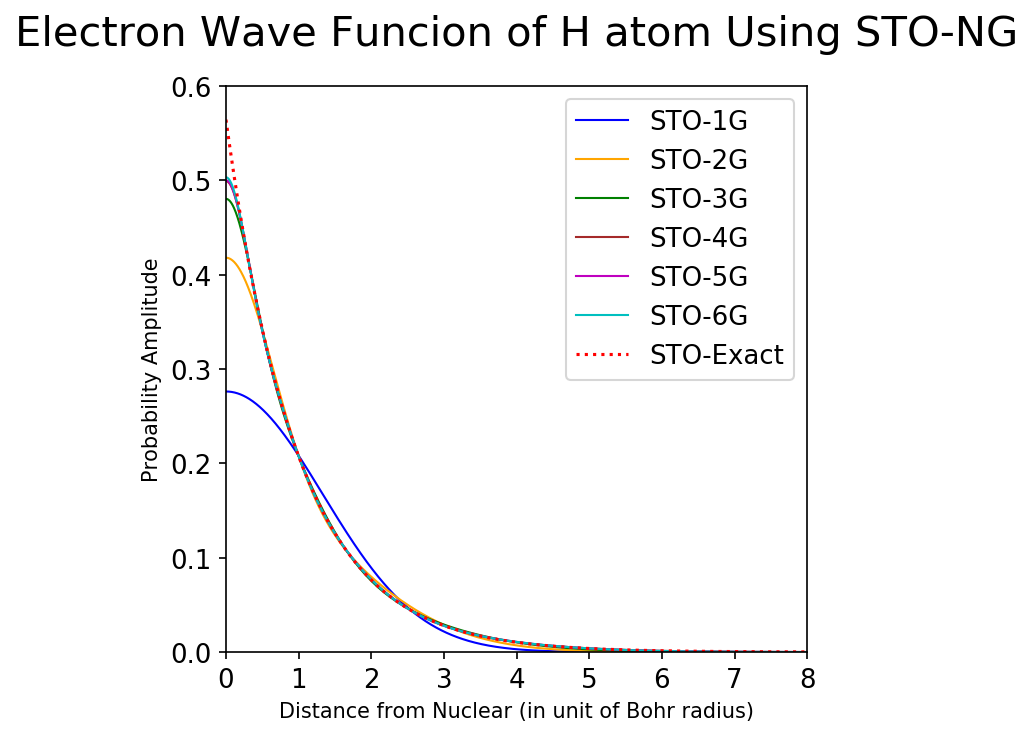

In [6]:
fig = plt.figure(figsize=(5,5), dpi = 150)
color =['blue','orange','green','brown','m' ,'c']
for i,curve in enumerate(ϕ):
    ax = plt.plot(r,curve, label= f'STO-{STO_NG[i]}G', c=color[i], lw=1.0 )
ax = plt.plot(r,1/np.pi**0.5*np.exp(-r),'r:', markersize = 1.0, label='STO-Exact' )

ax = plt.xticks(np.linspace(0,10,11),fontsize=12.5)
ax = plt.yticks(np.linspace(0,1.0,11),fontsize=12.5)
ax = plt.title('Electron Wave Funcion of H atom Using STO-NG', fontsize = 20, y=1.05)
ax = plt.xlabel('Distance from Nuclear (in unit of Bohr radius)')
ax = plt.ylabel('Probability Amplitude')
ax = plt.xlim(0,8)
ax = plt.ylim(0,0.6)
ax = plt.legend(loc='upper right', prop={'size': 12.5})

plt.show()

### See what will happen by putting in the reference coefficients into our gradient descend. 
Using the reference coefficients, we see that there is region whose energy is even lower than the reference. But unless we are extremely patient, it seems quite impossible to get there starting from our initial guess, since the gradient around the energy minimum is very, very small.

In [7]:
STO_NG = np.array([5,6])
E_and_norm = np.zeros((len(STO_NG),2))
for i,N in enumerate(STO_NG):   
    resolution = 5e-2
    criteria = 1e-4
    iter_max = 10000
    iteration = 0
    factor = 10

    if N==5:
        c=c5
        α=α5
    elif N==6:
        c=c6
        α=α6
    grad_E=np.zeros((2*N))
    grad_Richardson(N,resolution)  

    error = (grad_E@grad_E)**0.5
    η = α.min()
    c -= self_adj(error,η,factor)*grad_E[0:N]
    α -= self_adj(error,η,factor)*grad_E[N:]
    
    print(f'For STO-{N}G:')

    while error>criteria and iteration<iter_max:
        grad_Richardson(N,resolution)
    
        error  = (grad_E@grad_E)**0.5
        η = α.min()
        iteration += 1
    
        c -= self_adj(error,η,factor)*grad_E[0:N]
        α -= self_adj(error,η,factor)*grad_E[N:]
    
        if iteration%1000 == 0:
            print(f'\tIteration = {iteration}; Energy = {total_E(c,α, N)[0]:.10f}; Error = {error:.4e}')
    print('\n')

For STO-5G:
	Iteration = 1000; Energy = -0.4995066888; Error = 2.4269e-04
	Iteration = 2000; Energy = -0.4995068125; Error = 2.4229e-04
	Iteration = 3000; Energy = -0.4995069333; Error = 2.4218e-04
	Iteration = 4000; Energy = -0.4995070530; Error = 2.4216e-04
	Iteration = 5000; Energy = -0.4995071721; Error = 2.4221e-04
	Iteration = 6000; Energy = -0.4995072908; Error = 2.4233e-04
	Iteration = 7000; Energy = -0.4995074091; Error = 2.4252e-04
	Iteration = 8000; Energy = -0.4995075272; Error = 2.4275e-04
	Iteration = 9000; Energy = -0.4995076452; Error = 2.4304e-04
	Iteration = 10000; Energy = -0.4995077630; Error = 2.4337e-04


For STO-6G:
	Iteration = 1000; Energy = -0.4998261559; Error = 2.6931e-04
	Iteration = 2000; Energy = -0.4998261501; Error = 2.6918e-04
	Iteration = 3000; Energy = -0.4998261448; Error = 2.6977e-04
	Iteration = 4000; Energy = -0.4998261385; Error = 2.7054e-04
	Iteration = 5000; Energy = -0.4998261312; Error = 2.7140e-04
	Iteration = 6000; Energy = -0.4998261226; 